In [1]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import copy
import joblib
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import HistGradientBoostingClassifier

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Constants
lr = 1e-3
weight_decay = 1e-4
batch_size = 32
num_epochs = 75
num_runs = 3
max_patience = 13

# pd 
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Using device: cuda


In [2]:
def load_datasets(base_path="./"):
    
    files = {"train": "cs-training.csv"}
    dfs = {}
    
    for key, filename in files.items():
        print(f"Loading {filename}...")
        dfs[key] = pd.read_csv(base_path + filename, index_col=0)
        print(f"Loaded {filename} with {len(dfs[key].columns)} columns")
        
    return dfs

def dataset_summary(df, show_counts=True):
    
    total_rows = len(df)
    total_duplicates = df.duplicated().sum()
    
    summary = pd.DataFrame({
        "dtype": df.dtypes,
        "non_null_count": df.notna().sum(),
        "missing_count": df.isna().sum(),
        "missing_%": (df.isna().mean() * 100).round(2),
        "unique_count": df.nunique(),
        "duplicates_in_dataset": total_duplicates
    })
    
    print(f"Dataset shape: {df.shape}")
    if show_counts:
        print(f"Total rows: {total_rows}")
        print(f"Total duplicate rows: {total_duplicates}")
    summary = summary.sort_values(by="missing_%", ascending=False)
    
    return summary

def outlier_handling(df, target_col, threshold_high=99, threshold_low=1):
    
    df_copy = df.copy()
    
    numeric_cols = df_copy.select_dtypes(include=["number"]).columns.tolist()
    df_copy[numeric_cols] = df_copy[numeric_cols].fillna(0)
    
    X = df_copy.drop(columns=[target_col])
    y = df_copy[target_col]

    hgb = HistGradientBoostingClassifier(
        max_iter=100,
        random_state=42,
        min_samples_leaf=20
    )
    hgb.fit(X, y)

    y_pred_proba = hgb.predict_proba(X)[:, 1]

    high_val = np.percentile(y_pred_proba, threshold_high)
    low_val = np.percentile(y_pred_proba, threshold_low)

    mask = (y_pred_proba < high_val) & (y_pred_proba > low_val)
    df_filtered = df_copy.loc[mask].reset_index(drop=True)

    print(f"Dropped: {len(df_copy) - len(df_filtered)} outlier rows")

    return df_filtered

def drop_target_and_ids(df):
    
    df_copy = df.copy()
    feature_cols_to_drop = ["SeriousDlqin2yrs"]
    target = df_copy["SeriousDlqin2yrs"]
    df_raw_features = df_copy.drop(columns=feature_cols_to_drop)
    
    print(f"Dropped cols: {feature_cols_to_drop}")
    
    return df_raw_features, target, feature_cols_to_drop

def engineer_features(df):
    
    df_e = df.copy()

    TotalPastDue = (
        df_e["NumberOfTime30-59DaysPastDueNotWorse"].fillna(0)
        + df_e["NumberOfTimes90DaysLate"].fillna(0)
        + df_e["NumberOfTime60-89DaysPastDueNotWorse"].fillna(0)
    )

    RevolvingUtilizationOfUnsecuredLines = np.log1p(df_e["RevolvingUtilizationOfUnsecuredLines"].fillna(0))

    df_e["MajorDelinquencyBinary"] = (
        (df_e["NumberOfTimes90DaysLate"].fillna(0) > 0) |
        (df_e["NumberOfTime60-89DaysPastDueNotWorse"].fillna(0) > 0)
    ).astype(int)
    
    df_e["HasDelinquencies"] = (TotalPastDue > 0).astype(int)

    df_e["NormalizedUtilization"] = np.sqrt(RevolvingUtilizationOfUnsecuredLines)
    
    df_e["DelinquencyInteraction"] = TotalPastDue * RevolvingUtilizationOfUnsecuredLines
    
    df_e["NormalizedUtilization"] = np.sqrt(RevolvingUtilizationOfUnsecuredLines)
    
    age_denominator = df_e["age"].replace(0, np.nan)
    
    credit_line_denominator = df_e["NumberOfOpenCreditLinesAndLoans"].replace(0, np.nan)
    
    MonthlyIncome_safe = np.log1p(df_e["MonthlyIncome"].fillna(1.0))
    
    DebtRatio_safe = np.log1p(df_e["DebtRatio"].fillna(0))

    df_e["UtilizationPerAge"] = RevolvingUtilizationOfUnsecuredLines / age_denominator
    
    df_e["LatePaymentsPerAge"] = TotalPastDue / age_denominator
    
    df_e["LatePaymentsPerCreditLine"] = TotalPastDue / credit_line_denominator
    
    df_e["TotalPastDue_Squared"] = TotalPastDue ** 2

    df_e['90DaysLate_Squared'] = df_e['NumberOfTimes90DaysLate'].fillna(0) ** 2
    
    df_e["IncomePerCreditLine"] = MonthlyIncome_safe / (df_e["NumberOfOpenCreditLinesAndLoans"].fillna(0) + 1)
    
    df_e["DebtToIncome"] = DebtRatio_safe * MonthlyIncome_safe

    df_e["AgeRisk"] = np.where(df_e["age"].fillna(0) < 25, 1,
                     np.where(df_e["age"].fillna(0) < 35, 0.8,
                     np.where(df_e["age"].fillna(0) < 50, 0.6, 0.4)))
    
    utilization_bins = [-0.01, 0.1, 0.3, 0.6, 0.9, 1.5, 10]
    utilization_labels = ["Very Low", "Low", "Moderate", "High", "Very High", "Extreme"]
    df_e["UtilizationBucket"] = pd.cut(RevolvingUtilizationOfUnsecuredLines, bins=utilization_bins, labels=utilization_labels)

    late_bins = [-1, 0, 1, 3, 6, np.inf]
    late_labels = ["NoLate", "FewLate", "ModerateLate", "FrequentLate", "ChronicLate"]
    df_e["LatePaymentBucket"] = pd.cut(TotalPastDue, bins=late_bins, labels=late_labels)

    df_e = df_e.drop(
        ["RevolvingUtilizationOfUnsecuredLines", 
         "NumberOfTimes90DaysLate",
         "NumberRealEstateLoansOrLines",
         "DebtRatio",
         "MonthlyIncome", 
         "NumberOfOpenCreditLinesAndLoans",
         "NumberOfTime30-59DaysPastDueNotWorse",
         "NumberOfTime60-89DaysPastDueNotWorse",
         "age",
         "NumberOfDependents",
        ], axis=1, errors='ignore')

    print(f"Engineered: {len(df_e)} feature cols")
    print(f"Engineered cols: {list(df_e)}")

    return df_e
    
def drop_high_missing_cols(df, threshold=0.3):

    missing_frac = df.isna().mean().sort_values(ascending=False)
    missing_summary = pd.DataFrame({
        'MissingCount': df.isna().sum(),
        'MissingPercent': (missing_frac * 100).round(2)
    })

    if df.isna().sum().sum() > 0:
        print(missing_summary.to_string())
    
    hm_cols_to_drop = missing_frac[missing_frac > threshold].index.tolist()
    
    if hm_cols_to_drop:
        df_drop = df.drop(columns=hm_cols_to_drop)
        print(f"Dropped: {len(hm_cols_to_drop)} high missing cols")
        print(f"Dropped cols: {hm_cols_to_drop}")
    else:
        df_drop = df.copy()
        print("No high missing cols dropped")
        
    return df_drop, hm_cols_to_drop

def drop_high_card_cols(df, threshold=50):

    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    unique_counts = df[cat_cols].nunique().sort_values(ascending=False)
    unique_summary = pd.DataFrame({
        'UniqueCount': unique_counts,
        'UniquePercent': (unique_counts / len(df) * 100).round(2)
    })

    if cat_cols:
        print(unique_summary.to_string())

    hc_cols_to_drop = unique_counts[unique_counts > threshold].index.tolist()

    if hc_cols_to_drop:
        df_high = df.drop(columns=hc_cols_to_drop, errors='ignore')
        print(f"Dropped: {len(hc_cols_to_drop)} high cardinality cols")
        print(f"Dropped cols: {hc_cols_to_drop}")
    else:
        df_high = df.copy()
        print("No high cardinality cols dropped")

    return df_high, hc_cols_to_drop

def collapse_rare_categories(df, threshold=0.005):
    
    df_copy = df.copy()
    
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    
    rare_maps = {}

    for col in cat_cols:
        freqs = df_copy[col].value_counts(normalize=True, dropna=True)
        rare_cats = [c for c in freqs[freqs < threshold].index]
        if rare_cats:
            df_copy[col] = df_copy[col].astype('object').replace(rare_cats, 'Other').astype('category')
            rare_maps[col] = set(rare_cats)
            print(f"Column '{col}': collapsed {len(rare_cats)} rare categories -> {rare_cats}")
        else:
            print(f"Column '{col}': no rare categories to collapse")
        
        if df_copy[col].isna().any():
            df_copy[col] = df_copy[col].cat.add_categories('Unknown')
            df_copy[col] = df_copy[col].fillna('Unknown')

    return df_copy, rare_maps

def select_features(df, target, n_to_keep=10, random_state=42, bias_mode=None):
    
    df_temp = df.copy()
    
    cat_cols = df_temp.select_dtypes(include=["object", "category"]).columns.tolist()
    for col in cat_cols:
        df_temp[col] = df_temp[col].astype("category").cat.codes
    
    feature_cols = df_temp.columns.tolist()

    X_train, X_val, y_train, y_val = train_test_split(
        df_temp[feature_cols], target, test_size=0.2, random_state=random_state, stratify=target
    )

    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)

    neg_count = (y_train == 0).sum()
    pos_count = (y_train == 1).sum()

    if bias_mode is True:
        scale_pos_weight = pos_count / neg_count
    elif bias_mode is False:
        scale_pos_weight = neg_count / pos_count
    else:
        scale_pos_weight = 1

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=scale_pos_weight,
        learning_rate=0.03,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.7,
        gamma=0.5,
        reg_alpha=0.05,
        reg_lambda=0.8,
        n_estimators=1500,
        random_state=random_state,
        n_jobs=-1,
        verbosity=0,
    )

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    importance_dict = model.get_booster().get_score(importance_type="gain")
    importance_df = (
        pd.DataFrame({
            "Feature": list(importance_dict.keys()),
            "Importance": list(importance_dict.values())
        })
        .sort_values("Importance", ascending=False)
        .reset_index(drop=True)
    )

    xgb.plot_importance(model, importance_type="gain", max_num_features=X_train.shape[1])
    plt.title("Top Feature Importances (Gain)")
    plt.show()

    top_features = importance_df["Feature"].head(n_to_keep).tolist()
    final_features = list(set(top_features + cat_cols))
    to_drop = [col for col in feature_cols if col not in final_features]

    df_selected = df[final_features].copy()

    print(importance_df)
    print(f"Kept: {len(final_features)} select features")
    print(f"Kept cols: {final_features}")
    print(f"Dropped: {len(to_drop)} select features")
    print(f"Dropped cols: {to_drop}")

    return df_selected, to_drop
    
def impute_and_scale(df):
    
    df_copy = df.copy()

    num_col_order = df_copy.select_dtypes(include=['number']).columns.tolist()
    cat_col_order = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    
    num_imputer = SimpleImputer(strategy='median') if num_col_order else None
    robust_scaler, std_scaler = None, None
    cat_maps = {}
    skewed_cols = []

    if num_col_order:
        df_copy[num_col_order] = df_copy[num_col_order].replace([np.inf, -np.inf], np.nan)
        for col in num_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        df_copy[num_col_order] = num_imputer.fit_transform(df_copy[num_col_order])
        
        skewness = pd.DataFrame(df_copy[num_col_order]).skew().sort_values(ascending=False)
        skewed_cols = skewness[abs(skewness) > 1.0].index.tolist()
        normal_cols = [c for c in num_col_order if c not in skewed_cols]
        
        if skewed_cols:
            robust_scaler = RobustScaler()
            df_copy[skewed_cols] = robust_scaler.fit_transform(df_copy[skewed_cols])
        if normal_cols:
            std_scaler = StandardScaler()
            df_copy[normal_cols] = std_scaler.fit_transform(df_copy[normal_cols])

    if cat_col_order:
        for col in cat_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)           
            unique_vals = df_copy[col].dropna().unique().tolist()
            cat_maps[col] = {val: i for i, val in enumerate(unique_vals)}
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_copy[cat_col_order] = cat_imputer.fit_transform(df_copy[cat_col_order])  

    print("Imputed, flagged, scaled, and mapped features")

    return df_copy, num_imputer, cat_imputer, robust_scaler, std_scaler, num_col_order, skewed_cols, cat_col_order, cat_maps

def transform_val_test(
    df, 
    cols_to_drop=None, 
    num_imputer=None,
    cat_imputer=None,
    robust_scaler=None, 
    std_scaler=None,
    num_col_order=None, 
    skewed_cols=None,
    cat_col_order=None,
    cat_maps=None,
    rare_maps=None,
    train_columns=None
):
    
    df_copy = df.copy()

    if cols_to_drop:
        df_copy = df_copy.drop(columns=cols_to_drop, errors='ignore')

    if num_col_order:
        df_copy[num_col_order] = df_copy[num_col_order].replace([np.inf, -np.inf], np.nan)
        for col in num_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        df_copy[num_col_order] = num_imputer.transform(df_copy[num_col_order])

        if skewed_cols and robust_scaler:
            df_copy[skewed_cols] = robust_scaler.transform(df_copy[skewed_cols])
        if std_scaler:
            normal_cols = [c for c in num_col_order if not skewed_cols or c not in skewed_cols]
            df_copy[normal_cols] = std_scaler.transform(df_copy[normal_cols])
            
    if cat_col_order:
        for col in cat_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
            if rare_maps and col in rare_maps:
                rare_cats = rare_maps[col]
                df_copy[col] = df_copy[col].apply(lambda x: 'Other' if x in rare_cats else x)
            df_copy[col] = df_copy[col].fillna('Unknown')
        df_copy[cat_col_order] = cat_imputer.transform(df_copy[cat_col_order])

    if train_columns is not None:
        df_copy = df_copy.reindex(columns=train_columns, fill_value=0)

    print("Imputed, flagged, and scaled features")
    
    return df_copy

def check_and_drop_duplicates(df, target=None, drop_target_na=False, show_info=True):
    
    df_cleaned = df.copy()
    target_cleaned = None
    
    total_duplicates = df_cleaned.duplicated().sum()
    if total_duplicates > 0:
        df_cleaned = df_cleaned.drop_duplicates(keep='first')
        if show_info:
            print(f"Dropped {total_duplicates} duplicate rows. Remaining: {len(df_cleaned)}")
    
    if target is not None:
        target_cleaned = pd.Series(target).reindex(df_cleaned.index)
        if drop_target_na:
            mask = target_cleaned.notna()
            dropped = len(target_cleaned) - mask.sum()
            if dropped > 0 and show_info:
                print(f"Dropped {dropped} rows with missing target values")
            df_cleaned = df_cleaned.loc[mask].reset_index(drop=True)
            target_cleaned = target_cleaned.loc[mask].reset_index(drop=True)
        else:
            target_cleaned = target_cleaned.reset_index(drop=True)
        return df_cleaned, target_cleaned
    else:
        return df_cleaned

def fast_fbeta_scores(y_true, y_probs, thresholds, beta=2):
    
    y_true = np.asarray(y_true)
    y_probs = np.asarray(y_probs)
    thresholds = np.asarray(thresholds)

    preds = y_probs[:, None] > thresholds[None, :] 

    TP = (preds & (y_true[:, None] == 1)).sum(axis=0)
    FP = (preds & (y_true[:, None] == 0)).sum(axis=0)
    FN = ((~preds) & (y_true[:, None] == 1)).sum(axis=0)

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)

    beta_sq = beta ** 2
    f_beta = (1 + beta_sq) * (precision * recall) / (beta_sq * precision + recall + 1e-8)

    return f_beta

In [3]:
# Load datasets
dfs = load_datasets()
df_train = dfs["train"]

Loading cs-training.csv...
Loaded cs-training.csv with 11 columns


In [4]:
#summary
print(dataset_summary(df_train))
df_train.head(5)

Dataset shape: (150000, 11)
Total rows: 150000
Total duplicate rows: 609
                                        dtype  non_null_count  missing_count  \
MonthlyIncome                         float64          120269          29731   
NumberOfDependents                    float64          146076           3924   
SeriousDlqin2yrs                        int64          150000              0   
age                                     int64          150000              0   
RevolvingUtilizationOfUnsecuredLines  float64          150000              0   
DebtRatio                             float64          150000              0   
NumberOfTime30-59DaysPastDueNotWorse    int64          150000              0   
NumberOfOpenCreditLinesAndLoans         int64          150000              0   
NumberOfTimes90DaysLate                 int64          150000              0   
NumberRealEstateLoansOrLines            int64          150000              0   
NumberOfTime60-89DaysPastDueNotWorse    int64  

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
# Drop duplicates
df_train = check_and_drop_duplicates(df_train)

Dropped 609 duplicate rows. Remaining: 149391


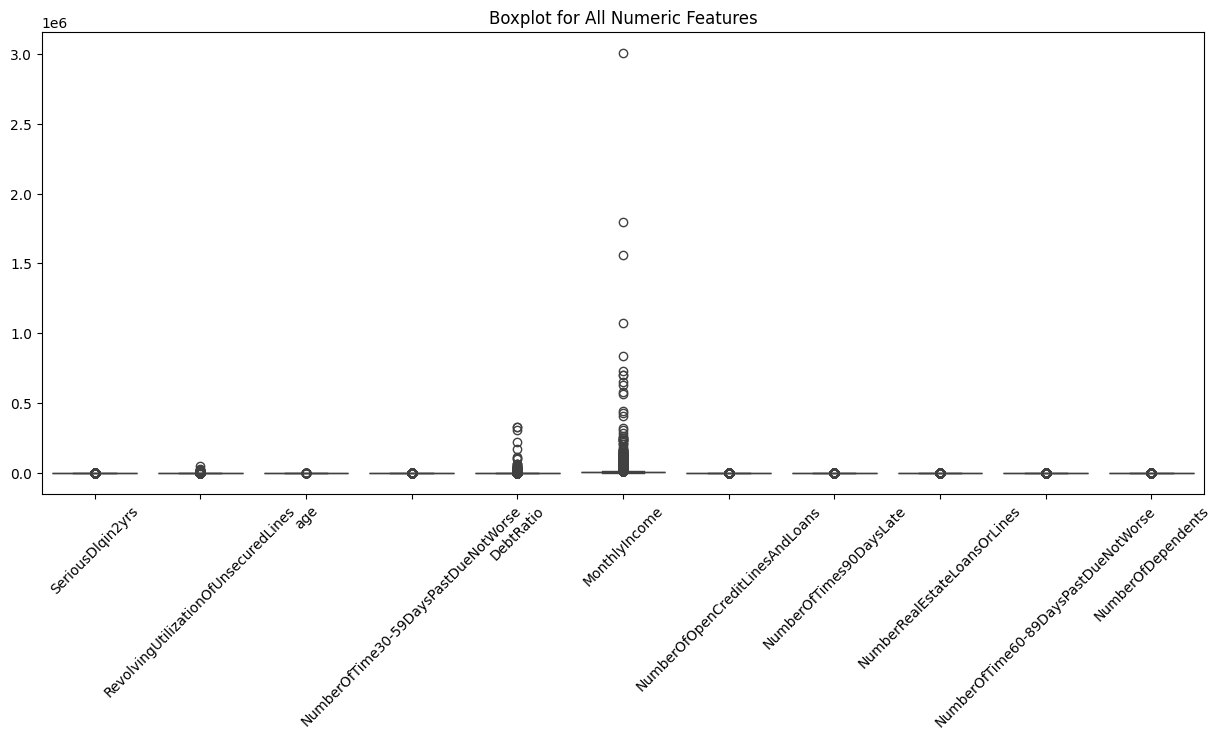

Dropped: 90 outlier rows


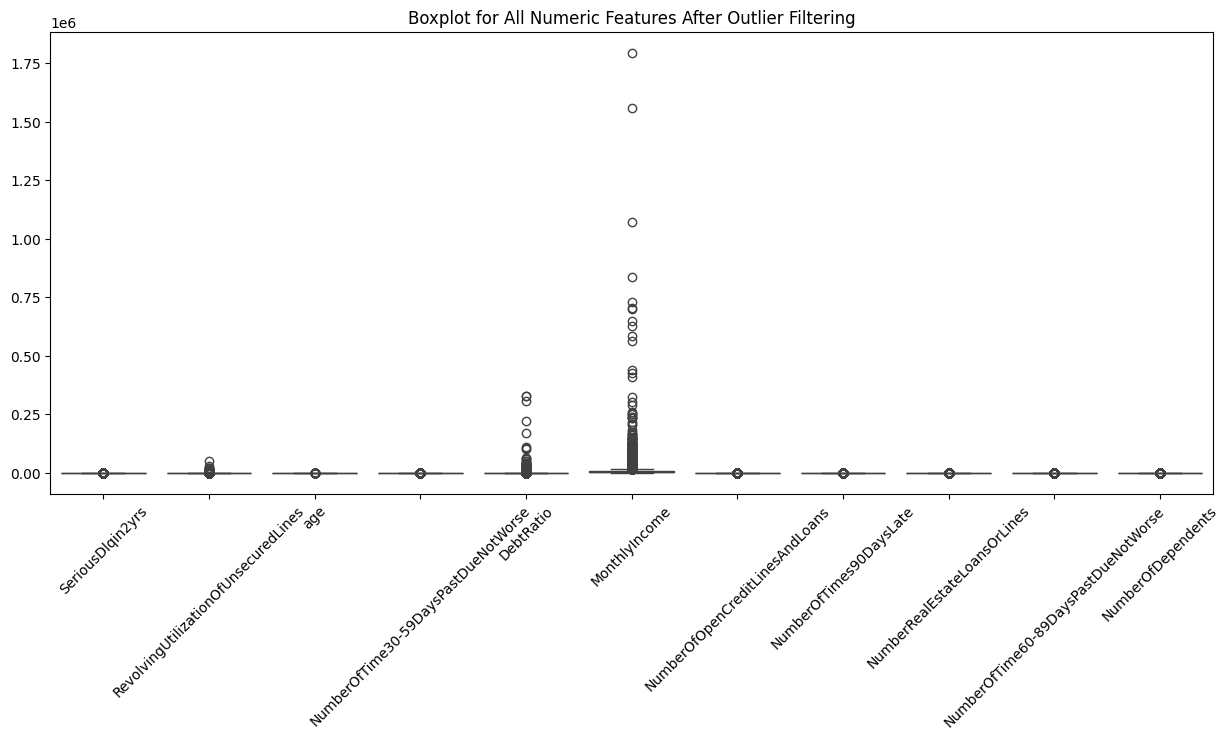

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149299.000000,149299.000000,149299.000000,149299.000000,149299.000000,1.492990e+05,149299.000000,149299.000000,149299.000000,149299.000000,149299.000000
mean,0.066759,6.074495,52.298348,0.390867,354.521242,5.351402e+03,8.482455,0.234235,1.022492,0.209399,0.740253
std,0.249604,250.340731,14.717123,3.820618,2042.403253,1.064165e+04,5.136889,3.792708,1.129994,3.777734,1.107901
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030159,41.000000,0.000000,0.177511,1.600000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154235,52.000000,0.000000,0.368232,4.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.556092,63.000000,0.000000,0.875062,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,1.794060e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [6]:
# Outlier Handling
numeric_df = df_train.select_dtypes(include=['number'])
plt.figure(figsize=(15, 6))
sns.boxplot(data=numeric_df)
plt.title("Boxplot for All Numeric Features")
plt.xticks(rotation=45)
plt.show()

df_train = df_train[df_train['age'] > 0].reset_index(drop=True) 

df_train = df_train.sort_values(by="MonthlyIncome", ascending=False).iloc[1:].reset_index(drop=True) 

df_train = df_train[df_train['age'] > 0].reset_index(drop=True)

df_filtered = outlier_handling(
    df_train,
    target_col="SeriousDlqin2yrs",
    threshold_high=99.97,
    threshold_low=0.03
)

numeric_df = df_filtered.select_dtypes(include=['number'])
plt.figure(figsize=(15, 6))
sns.boxplot(data=numeric_df)
plt.title("Boxplot for All Numeric Features After Outlier Filtering")
plt.xticks(rotation=45)
plt.show()

df_filtered.describe()

In [7]:
# Select targets
df_features, target, feature_cols_to_drop = drop_target_and_ids(df_filtered)
print(target.value_counts())

Dropped cols: ['SeriousDlqin2yrs']
SeriousDlqin2yrs
0    139332
1      9967
Name: count, dtype: int64


In [8]:
original_cols = df_features.select_dtypes(include=['number']).columns.tolist()
print(original_cols)

['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


In [9]:
# Split train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df_features, target, test_size=0.2, stratify=target, random_state=42
)

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

In [10]:
#Engineer_features
df_e = engineer_features(X_train)

Engineered: 95551 feature cols
Engineered cols: ['MajorDelinquencyBinary', 'HasDelinquencies', 'NormalizedUtilization', 'DelinquencyInteraction', 'UtilizationPerAge', 'LatePaymentsPerAge', 'LatePaymentsPerCreditLine', 'TotalPastDue_Squared', '90DaysLate_Squared', 'IncomePerCreditLine', 'DebtToIncome', 'AgeRisk', 'UtilizationBucket', 'LatePaymentBucket']


In [11]:
# Drop columns with missing
df_drop, hm_cols_to_drop = drop_high_missing_cols(df_e, threshold=0.25)

                           MissingCount  MissingPercent
90DaysLate_Squared                    0            0.00
AgeRisk                               0            0.00
DebtToIncome                          0            0.00
DelinquencyInteraction                0            0.00
HasDelinquencies                      0            0.00
IncomePerCreditLine                   0            0.00
LatePaymentBucket                     0            0.00
LatePaymentsPerAge                    0            0.00
LatePaymentsPerCreditLine          1098            1.15
MajorDelinquencyBinary                0            0.00
NormalizedUtilization                 0            0.00
TotalPastDue_Squared                  0            0.00
UtilizationBucket                     3            0.00
UtilizationPerAge                     0            0.00
No high missing cols dropped


In [12]:
# Drop high card
df_high, hc_cols_to_drop = drop_high_card_cols(df_drop, threshold=50)

                   UniqueCount  UniquePercent
UtilizationBucket            6           0.01
LatePaymentBucket            5           0.01
No high cardinality cols dropped


In [13]:
# Collapse rare categories
df_collapsed, rare_maps = collapse_rare_categories(df_high, threshold=0.05)

Column 'UtilizationBucket': collapsed 2 rare categories -> ['Very High', 'Extreme']
Column 'LatePaymentBucket': collapsed 2 rare categories -> ['FrequentLate', 'ChronicLate']


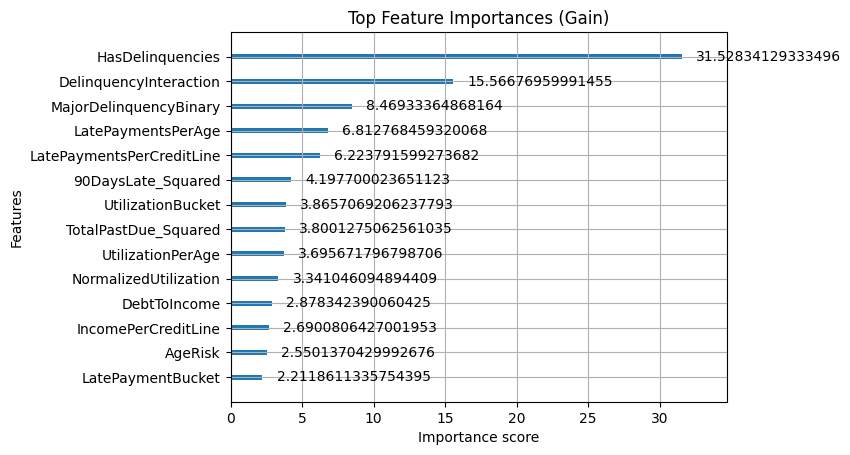

                      Feature  Importance
0            HasDelinquencies   31.528341
1      DelinquencyInteraction   15.566770
2      MajorDelinquencyBinary    8.469334
3          LatePaymentsPerAge    6.812768
4   LatePaymentsPerCreditLine    6.223792
5          90DaysLate_Squared    4.197700
6           UtilizationBucket    3.865707
7        TotalPastDue_Squared    3.800128
8           UtilizationPerAge    3.695672
9       NormalizedUtilization    3.341046
10               DebtToIncome    2.878342
11        IncomePerCreditLine    2.690081
12                    AgeRisk    2.550137
13          LatePaymentBucket    2.211861
Kept: 14 select features
Kept cols: ['AgeRisk', 'LatePaymentBucket', 'IncomePerCreditLine', 'MajorDelinquencyBinary', 'NormalizedUtilization', 'LatePaymentsPerCreditLine', 'DebtToIncome', 'TotalPastDue_Squared', 'HasDelinquencies', '90DaysLate_Squared', 'UtilizationPerAge', 'UtilizationBucket', 'DelinquencyInteraction', 'LatePaymentsPerAge']
Dropped: 0 select features

In [14]:
# Feature selection
df_selected, fs_cols_to_drop = select_features(df_collapsed, y_train, n_to_keep=13, bias_mode=None)

In [15]:
# Impute and scale
df_processed, num_imputer,  cat_imputer, robust_scaler, std_scaler, num_col_order, skewed_col_order, cat_col_order, cat_maps = impute_and_scale(
    df_selected
)

Imputed, flagged, scaled, and mapped features


In [16]:
# Skewed columns
print(num_col_order)
print(cat_col_order)
print(skewed_col_order)
print(rare_maps)
print(cat_maps)

['AgeRisk', 'IncomePerCreditLine', 'MajorDelinquencyBinary', 'NormalizedUtilization', 'LatePaymentsPerCreditLine', 'DebtToIncome', 'TotalPastDue_Squared', 'HasDelinquencies', '90DaysLate_Squared', 'UtilizationPerAge', 'DelinquencyInteraction', 'LatePaymentsPerAge']
['LatePaymentBucket', 'UtilizationBucket']
['LatePaymentsPerCreditLine', 'LatePaymentsPerAge', 'TotalPastDue_Squared', '90DaysLate_Squared', 'DelinquencyInteraction', 'UtilizationPerAge', 'IncomePerCreditLine', 'MajorDelinquencyBinary', 'DebtToIncome', 'HasDelinquencies', 'AgeRisk']
{'UtilizationBucket': {'Very High', 'Extreme'}, 'LatePaymentBucket': {'ChronicLate', 'FrequentLate'}}
{'LatePaymentBucket': {'NoLate': 0, 'ModerateLate': 1, 'FewLate': 2, 'Other': 3}, 'UtilizationBucket': {'Low': 0, 'Very Low': 1, 'Moderate': 2, 'High': 3, 'Other': 4, 'Unknown': 5}}


In [17]:
# Process
all_cols_to_drop = feature_cols_to_drop + hm_cols_to_drop + hc_cols_to_drop + fs_cols_to_drop

X_val = engineer_features(X_val)
X_val = transform_val_test(    
    X_val,
    all_cols_to_drop,
    num_imputer,
    cat_imputer,
    robust_scaler,
    std_scaler,
    num_col_order,
    skewed_col_order,
    cat_col_order,
    cat_maps,
    rare_maps,
    train_columns=df_processed.columns,
)

X_test = engineer_features(X_test)
X_test = transform_val_test(
    X_test,
    all_cols_to_drop,
    num_imputer,
    cat_imputer,
    robust_scaler,
    std_scaler,
    num_col_order,
    skewed_col_order,
    cat_col_order,
    cat_maps,
    rare_maps,
    train_columns=df_processed.columns,
)

X_train = df_processed.copy()

Engineered: 23888 feature cols
Engineered cols: ['MajorDelinquencyBinary', 'HasDelinquencies', 'NormalizedUtilization', 'DelinquencyInteraction', 'UtilizationPerAge', 'LatePaymentsPerAge', 'LatePaymentsPerCreditLine', 'TotalPastDue_Squared', '90DaysLate_Squared', 'IncomePerCreditLine', 'DebtToIncome', 'AgeRisk', 'UtilizationBucket', 'LatePaymentBucket']
Imputed, flagged, and scaled features
Engineered: 29860 feature cols
Engineered cols: ['MajorDelinquencyBinary', 'HasDelinquencies', 'NormalizedUtilization', 'DelinquencyInteraction', 'UtilizationPerAge', 'LatePaymentsPerAge', 'LatePaymentsPerCreditLine', 'TotalPastDue_Squared', '90DaysLate_Squared', 'IncomePerCreditLine', 'DebtToIncome', 'AgeRisk', 'UtilizationBucket', 'LatePaymentBucket']
Imputed, flagged, and scaled features


In [18]:
# Drop duplicates
X_train, y_train = check_and_drop_duplicates(X_train, y_train)

Dropped 2786 duplicate rows. Remaining: 92765


In [19]:
#summary
print(dataset_summary(X_train))

Dataset shape: (92765, 28)
Total rows: 92765
Total duplicate rows: 0
                                       dtype  non_null_count  missing_count  \
AgeRisk                              float64           92765              0   
LatePaymentBucket                     object           92765              0   
IncomePerCreditLine                  float64           92765              0   
MajorDelinquencyBinary               float64           92765              0   
NormalizedUtilization                float64           92765              0   
LatePaymentsPerCreditLine            float64           92765              0   
DebtToIncome                         float64           92765              0   
TotalPastDue_Squared                 float64           92765              0   
HasDelinquencies                     float64           92765              0   
90DaysLate_Squared                   float64           92765              0   
UtilizationPerAge                    float64           92765  

In [20]:
# Encode
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

cat_maps = {
    col: {cat: idx for idx, cat in enumerate(X_train[col].astype(str).unique())}
    for col in cat_cols
}

for col in cat_cols:
    X_train[col] = X_train[col].astype(str).map(cat_maps[col]).fillna(0).astype(int)
    X_val[col] = X_val[col].astype(str).map(cat_maps[col]).fillna(0).astype(int)
    X_test[col] = X_test[col].astype(str).map(cat_maps[col]).fillna(0).astype(int)

In [21]:
# Drop imputation flags for NN 
def drop_imputation_flags(df):
    imputed_flag_cols = [col for col in df.columns if col.startswith("Was") and col.endswith("Imputed")]
    df_nn = df.drop(columns=imputed_flag_cols, errors='ignore')
    print(f"Dropped: {len(imputed_flag_cols)} imputation flags")
    return df_nn

X_train_nn = drop_imputation_flags(X_train.copy())
X_val_nn = drop_imputation_flags(X_val.copy())
X_test_nn = drop_imputation_flags(X_test.copy())

Dropped: 14 imputation flags
Dropped: 14 imputation flags
Dropped: 14 imputation flags


In [22]:
# Separate numeric and categorical form embeding and cast to float32 and int64 
num_cols = [col for col in X_train_nn.columns if col not in cat_cols]

X_train_num = X_train_nn[num_cols].astype('float32').values
X_val_num = X_val_nn[num_cols].astype('float32').values
X_test_num = X_test_nn[num_cols].astype('float32').values

X_train_cat = X_train_nn[cat_cols].astype('int64').values
X_val_cat = X_val_nn[cat_cols].astype('int64').values
X_test_cat = X_test_nn[cat_cols].astype('int64').values

In [23]:
# Convert to tensors
X_train_num_tensor = torch.tensor(X_train_num)
X_val_num_tensor = torch.tensor(X_val_num)
X_test_num_tensor = torch.tensor(X_test_num)

X_train_cat_tensor = torch.tensor(X_train_cat)
X_val_cat_tensor = torch.tensor(X_val_cat)
X_test_cat_tensor = torch.tensor(X_test_cat)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights, strict=True))
weights_tensor = torch.tensor([class_weight_dict[int(c)] for c in y_train], dtype=torch.float32)

print("Numeric input shape:", X_train_num_tensor.shape)
print("Categorical input shape:", X_train_cat_tensor.shape)
print("Class weights:", class_weight_dict)

Numeric input shape: torch.Size([92765, 12])
Categorical input shape: torch.Size([92765, 2])
Class weights: {np.int64(0): np.float64(0.5361642853840107), np.int64(1): np.float64(7.412897554738692)}


In [24]:
# Datasets
class TabularDataset(Dataset):
    def __init__(self, x_num, x_cat, y):
        self.x_num = x_num
        self.x_cat = x_cat
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_num[idx], self.x_cat[idx], self.y[idx]

train_ds = TabularDataset(X_train_num_tensor, X_train_cat_tensor, y_train_tensor)
val_ds = TabularDataset(X_val_num_tensor, X_val_cat_tensor, y_val_tensor)
test_ds = TabularDataset(X_test_num_tensor, X_test_cat_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 92765, Val: 23888, Test: 29860


In [25]:
# Model
class NN(nn.Module):
    def __init__(self, num_numeric, cat_dims, emb_dims):
        super().__init__()

        self.emb_layers = nn.ModuleList([
            nn.Embedding(cat_dim, emb_dim)
            for cat_dim, emb_dim in zip(cat_dims, emb_dims, strict=True)
        ])
        self.emb_dropout = nn.Dropout(0.3)

        self.bn_num = nn.BatchNorm1d(num_numeric)

        total_emb_dim = sum(emb_dims)
        self.input_dim = num_numeric + total_emb_dim

        self.main = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.skip_proj_main = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            nn.Dropout(0.3)
        )

        self.cat_skip = nn.Sequential(
            nn.Linear(total_emb_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        self.out = nn.Linear(64, 1)

    def forward(self, x_num, x_cat):
    
        x_cat_emb = torch.cat([
            emb(x_cat[:, i]) for i, emb in enumerate(self.emb_layers)
        ], dim=1)
        x_cat_emb = self.emb_dropout(x_cat_emb)

        x_num = self.bn_num(x_num)

        x = torch.cat([x_num, x_cat_emb], dim=1)

        x_main = self.main(x)

        x_skip = self.skip_proj_main(x) + self.cat_skip(x_cat_emb)

        x_combined = x_main + x_skip
        
        return self.out(x_combined).squeeze(1)

cat_dims = [len(cat_maps[col]) for col in cat_cols]
emb_dims = [min(50, (cat_dim + 1) // 2) for cat_dim in cat_dims]

model = NN(X_train_num.shape[1], cat_dims, emb_dims).to(device)
print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters()))

NN(
  (emb_layers): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(6, 3)
  )
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (bn_num): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (main): Sequential(
    (0): Linear(in_features=17, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (skip_proj_main): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): Dropout(p=0.3, inplace=False

In [26]:
# Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(
            logits,
            targets,
            reduction='none',
            pos_weight=torch.tensor(self.pos_weight, device=logits.device)
            if self.pos_weight else None
        )
        p_t = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * bce_loss
        return focal_loss.mean()

alpha = class_weights[1] / (class_weights[0] + class_weights[1])
loss_fn = FocalLoss(alpha=alpha, gamma=3)

In [27]:
# Train
overall_best_val_auc = 0.0
overall_best_model_state = None

for run in range(num_runs):
    print(f"\n=== Run {run + 1}/{num_runs} ===")

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.5
    )

    best_val_auc_this_run = 0.0
    best_model_state_this_run = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        train_logits, train_labels = [], []

        for x_num, x_cat, yb in train_loader:
            x_num, x_cat, yb = x_num.to(device), x_cat.to(device), yb.to(device).float()
        
            optimizer.zero_grad()
            logits = model(x_num, x_cat)  
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * x_num.size(0)
            train_logits.append(logits.detach().cpu())
            train_labels.append(yb.cpu())

        train_loss = total_train_loss / len(train_loader.dataset)
        train_logits = torch.cat(train_logits)
        train_labels = torch.cat(train_labels)
        train_probs = torch.sigmoid(train_logits).numpy()
        train_auc = roc_auc_score(train_labels.numpy(), train_probs)

        model.eval()
        total_val_loss = 0.0
        val_logits, val_labels = [], []

        with torch.no_grad():
            for x_num, x_cat, yb in val_loader:
                x_num, x_cat, yb = x_num.to(device), x_cat.to(device), yb.to(device).float()
                logits = model(x_num, x_cat)
            
                loss = loss_fn(logits, yb)
                total_val_loss += loss.item() * x_num.size(0)
                val_logits.append(logits.cpu())
                val_labels.append(yb.cpu())

        val_loss = total_val_loss / len(val_loader.dataset)
        val_logits = torch.cat(val_logits)
        val_labels = torch.cat(val_labels)
        val_probs = torch.sigmoid(val_logits).numpy()
        val_auc = roc_auc_score(val_labels.numpy(), val_probs)

        if val_auc > best_val_auc_this_run:
            best_val_auc_this_run = val_auc
            best_model_state_this_run = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        scheduler.step(val_auc)

        print(f"Epoch {epoch + 1}/{num_epochs} | "
              f"Train loss: {train_loss:.6f} | Train AUC: {train_auc:.4f} | "
              f"Val loss: {val_loss:.6f} | Val AUC: {val_auc:.4f}")

    print(f"Run {run + 1} best Val AUC: {best_val_auc_this_run:.4f}")

    if best_val_auc_this_run > overall_best_val_auc:
        overall_best_val_auc = best_val_auc_this_run
        overall_best_model_state = copy.deepcopy(best_model_state_this_run)

model.load_state_dict(overall_best_model_state)
print(f"\nBest model across all runs restored (Val AUC = {overall_best_val_auc:.4f})")


=== Run 1/3 ===
Epoch 1/75 | Train loss: 0.028745 | Train AUC: 0.8064 | Val loss: 0.024815 | Val AUC: 0.8546
Epoch 2/75 | Train loss: 0.025501 | Train AUC: 0.8414 | Val loss: 0.024580 | Val AUC: 0.8564
Epoch 3/75 | Train loss: 0.025286 | Train AUC: 0.8442 | Val loss: 0.024937 | Val AUC: 0.8534
Epoch 4/75 | Train loss: 0.025157 | Train AUC: 0.8462 | Val loss: 0.024913 | Val AUC: 0.8603
Epoch 5/75 | Train loss: 0.025121 | Train AUC: 0.8464 | Val loss: 0.024373 | Val AUC: 0.8598
Epoch 6/75 | Train loss: 0.025060 | Train AUC: 0.8477 | Val loss: 0.024452 | Val AUC: 0.8603
Epoch 7/75 | Train loss: 0.025016 | Train AUC: 0.8480 | Val loss: 0.024321 | Val AUC: 0.8610
Epoch 8/75 | Train loss: 0.024954 | Train AUC: 0.8490 | Val loss: 0.024415 | Val AUC: 0.8609
Epoch 9/75 | Train loss: 0.024951 | Train AUC: 0.8499 | Val loss: 0.024642 | Val AUC: 0.8597
Epoch 10/75 | Train loss: 0.024858 | Train AUC: 0.8512 | Val loss: 0.024363 | Val AUC: 0.8614
Epoch 11/75 | Train loss: 0.024829 | Train AUC: 0.85

Best threshold for F1: 0.35487068
              precision    recall  f1-score   support

      Repaid       0.97      0.88      0.92     27867
   Defaulted       0.27      0.66      0.39      1993

    accuracy                           0.86     29860
   macro avg       0.62      0.77      0.65     29860
weighted avg       0.93      0.86      0.89     29860

Accuracy: 86.06%
ROC AUC: 0.858
TP=1309, FP=3477, TN=24390, FN=684
Accuracy for class 'Repaid': 87.52%
Accuracy for class 'Defaulted': 65.68%


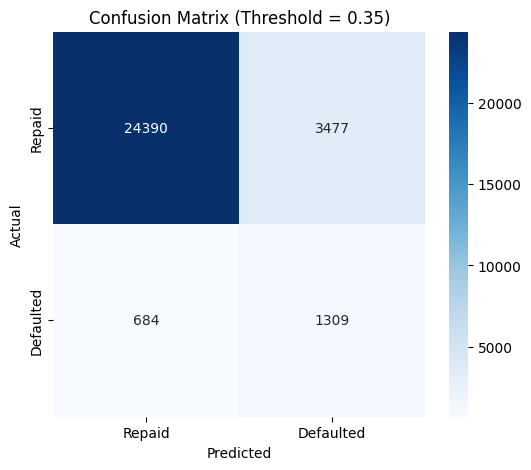

In [28]:
# Evaluation
model.eval()
y_val_probs = []

with torch.no_grad():
    for x_num, x_cat, _ in val_loader:  
        x_num, x_cat = x_num.to(device), x_cat.to(device)
        outputs = model(x_num, x_cat)
        probs = torch.sigmoid(outputs)
        y_val_probs.extend(probs.cpu().numpy())

y_val_probs = np.array(y_val_probs)

# Target defaults recall
prec, rec, thresholds = precision_recall_curve(y_val, y_val_probs)
f_beta_scores = fast_fbeta_scores(y_val, y_val_probs, thresholds, beta=2)
best_thresh_a = thresholds[np.argmax(f_beta_scores)]

y_test_probs = []
with torch.no_grad():
    for x_num, x_cat, _ in test_loader:
        x_num, x_cat = x_num.to(device), x_cat.to(device)
        outputs = model(x_num, x_cat)
        probs = torch.sigmoid(outputs)
        y_test_probs.extend(probs.cpu().numpy())

y_test_probs = np.array(y_test_probs)
y_test_pred_opt = (y_test_probs > best_thresh_a).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_test_pred_opt, target_names=target_names)
acc = accuracy_score(y_test, y_test_pred_opt)
roc_auc = roc_auc_score(y_test, y_test_probs)
cm = confusion_matrix(y_test, y_test_pred_opt)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("Best threshold for F1:", best_thresh_a)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh_a:.2f})")
plt.show()

In [29]:
# Cast to float32 
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

In [30]:
# Model
neg_count = sum(y_train == 0)
pos_count = sum(y_train == 1)

scale_pos_weight = neg_count / pos_count

model_b = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["auc"],
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.03,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.5,
    reg_alpha=0.05,
    reg_lambda=0.8,
    n_estimators=1500,
    random_state=42,
    n_jobs=-1,
    verbosity=1,
    early_stopping_rounds=100,
    callbacks=[xgb.callback.LearningRateScheduler(lambda epoch: 0.03 * (0.99 ** epoch))]
)

In [31]:
# Train
model_b.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

[0]	validation_0-auc:0.85377
[1]	validation_0-auc:0.85841
[2]	validation_0-auc:0.86020
[3]	validation_0-auc:0.86045
[4]	validation_0-auc:0.86065
[5]	validation_0-auc:0.86113
[6]	validation_0-auc:0.86151
[7]	validation_0-auc:0.86214
[8]	validation_0-auc:0.86245
[9]	validation_0-auc:0.86254
[10]	validation_0-auc:0.86288
[11]	validation_0-auc:0.86285
[12]	validation_0-auc:0.86277
[13]	validation_0-auc:0.86297
[14]	validation_0-auc:0.86299
[15]	validation_0-auc:0.86297
[16]	validation_0-auc:0.86324
[17]	validation_0-auc:0.86333
[18]	validation_0-auc:0.86329
[19]	validation_0-auc:0.86336
[20]	validation_0-auc:0.86343
[21]	validation_0-auc:0.86356
[22]	validation_0-auc:0.86351
[23]	validation_0-auc:0.86355
[24]	validation_0-auc:0.86357
[25]	validation_0-auc:0.86350
[26]	validation_0-auc:0.86347
[27]	validation_0-auc:0.86346
[28]	validation_0-auc:0.86345
[29]	validation_0-auc:0.86349
[30]	validation_0-auc:0.86350
[31]	validation_0-auc:0.86351
[32]	validation_0-auc:0.86352
[33]	validation_0-au

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,[<xgboost.call...x78234c1251d0>]
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,['auc']


Best threshold for F1: 0.59725696
              precision    recall  f1-score   support

      Repaid       0.97      0.87      0.92     27867
   Defaulted       0.27      0.68      0.38      1993

    accuracy                           0.85     29860
   macro avg       0.62      0.77      0.65     29860
weighted avg       0.93      0.85      0.88     29860

Accuracy: 85.38%
ROC AUC: 0.858
TP=1361, FP=3733, TN=24134, FN=632
Accuracy for class 'Repaid': 86.60%
Accuracy for class 'Defaulted': 68.29%


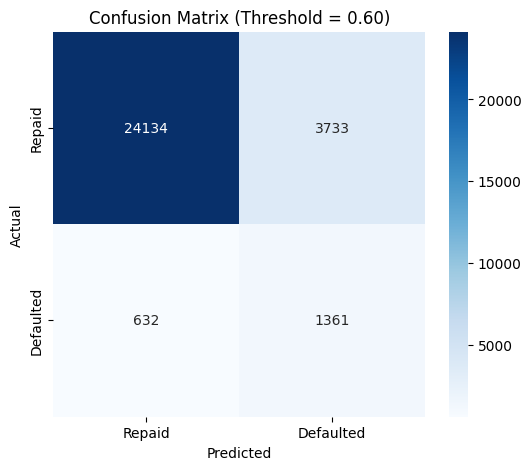

In [32]:
# Evaluation
y_probs = model_b.predict_proba(X_test)[:, 1]

# Target defaults recall
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
f_beta_scores = fast_fbeta_scores(y_test, y_probs, thresholds, beta=2)
best_thresh_b = thresholds[np.argmax(f_beta_scores)]

y_pred = (y_probs > best_thresh_b).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_pred, target_names=target_names)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)
roc_auc = roc_auc_score(y_test, y_probs)

print("Best threshold for F1:", best_thresh_b)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh_b:.2f})")
plt.show()

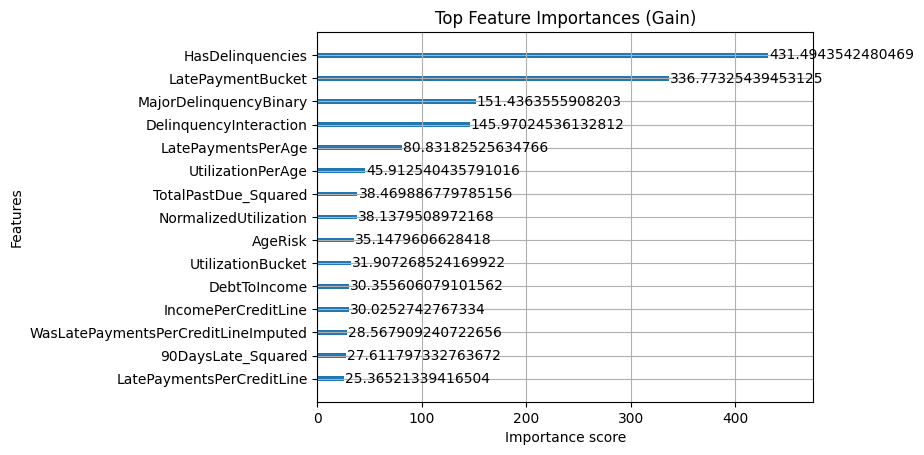

                                Feature  Importance
0                      HasDelinquencies  431.494354
1                     LatePaymentBucket  336.773254
2                MajorDelinquencyBinary  151.436356
3                DelinquencyInteraction  145.970245
4                    LatePaymentsPerAge   80.831825
5                     UtilizationPerAge   45.912540
6                  TotalPastDue_Squared   38.469887
7                 NormalizedUtilization   38.137951
8                               AgeRisk   35.147961
9                     UtilizationBucket   31.907269
10                         DebtToIncome   30.355606
11                  IncomePerCreditLine   30.025274
12  WasLatePaymentsPerCreditLineImputed   28.567909
13                   90DaysLate_Squared   27.611797
14            LatePaymentsPerCreditLine   25.365213


In [33]:
# Importance
importance_dict = model_b.get_booster().get_score(importance_type="gain")
importance_df = (
    pd.DataFrame({
        "Feature": list(importance_dict.keys()),
        "Importance": list(importance_dict.values())
    })
    .sort_values("Importance", ascending=False)
    .reset_index(drop=True)
)
xgb.plot_importance(model_b, importance_type='gain', max_num_features=X_train.shape[1])
plt.title("Top Feature Importances (Gain)")
plt.show()
print(importance_df)

In [34]:
# Save NN model
torch.save(model.state_dict(), "cr_weights.pth")

In [35]:
# Save xgb model
model_b.save_model("cr_b.json")

In [36]:
# Save for hosting
joblib.dump(best_thresh_a, "threshold_a.pkl")
joblib.dump(best_thresh_b, "threshold_b.pkl")
joblib.dump(num_imputer, "num_imputer.pkl")
joblib.dump(cat_imputer, "cat_imputer.pkl")
joblib.dump(robust_scaler, "robust_scaler.pkl")
joblib.dump(std_scaler, "std_scaler.pkl")
joblib.dump(num_col_order, "num_col_order.pkl")
joblib.dump(cat_maps, "cat_maps.pkl")
joblib.dump(cat_col_order, "cat_col_order.pkl")
joblib.dump(skewed_col_order, "skewed_col_order.pkl")
joblib.dump(rare_maps, "rare_maps.pkl")

['rare_maps.pkl']